# Natural Language Inference

This Jupyter Notebook fine-tunes `microsoft/xlm-roberta-large` on many NLI datasets.
It includes data loading, preprocessing, data augmentation, model training, evaluation, and visualization.

### Environment Setup

This notebook was executed on a local Jupyter server in a LXC connected to 4 GPU NVIDIA A100 80GB to train models.

#### Install dependencies

In [1]:
%pip install -qU pandas numpy seaborn matplotlib scikit-learn datasets evaluate
%pip install -qU "transformers[torch]"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
!export TOKENIZERS_PARALLELISM=false

#### Import libraries

In [3]:
from pathlib import Path
from tqdm import tqdm

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Dataset, concatenate_datasets, load_dataset
from transformers import AutoTokenizer, Trainer, TrainingArguments

#### Constants

In [4]:
PRETRAINED_MODEL_NAME = "FacebookAI/xlm-roberta-large"
ROOT_PATH = Path.cwd()
MODEL_DIR = ROOT_PATH / "models"
MODEL_BASENAME = PRETRAINED_MODEL_NAME.rpartition('/')[2]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use fixed seed for results reproducibility
np.random.seed(0)

### Data Loading

#### Challenge dataset

In [5]:
df = pd.read_csv(ROOT_PATH / "data/train.csv")

# Train-test spliting
challenge_dataset = Dataset.from_pandas(df).train_test_split(test_size=0.3, seed=0)
challenge_train = challenge_dataset['train']
challenge_val = challenge_dataset['test']

# Inspect the train dataset with 10 random row
df.sample(10)

,id,premise,hypothesis,lang_abv,language,label
6543,af77bed638,The experts point out that it is not age alone...,The Qin Dynasty has the most expensive antique...,en,English,1
9150,285d11dd62,Wear a nicely ventilated hat and keep to the s...,A sun umbrella might help those who really nee...,en,English,1
8245,00b1f84085,Each working group met several times to develo...,There were no meetings to discuss changes to t...,en,English,2
3753,e19376a801,farmworkers conducted by the U.S.,A labor survey also considered the views of ag...,en,English,1
713,b0afb96e00,كلمتا blood و flood ليس بنفس صوت food.,الغذاء هو بالضبط مثل الدم والفيضان.,ar,Arabic,2
2799,e33f803e46,"LSC set a deadline of October 1, 1998, for sub...",LSC set a deadline to submit state reports to ...,en,English,1
2335,45280f46e8,"Bila shaka, azimio lako lilikuwa la thamani, S...",Waspania walipanga kukutupa majini wakati wa u...,sw,Swahili,1
2397,0a9e0b89ab,"Eh! Monsieur Lawrence, called Poirot.",Poirot did not call upon Monsieur Lawrence.,en,English,2
3959,f093f8733c,Release 2.0: A Design for Living in the Digita...,Esther Dyson is the Author of Release 2.o: A D...,en,English,0
5808,49ba04c9a8,aCondition Assessment Survey (CAS).,CAS is a Condition Assessment Survey,en,English,0


Display label distribution: the dataset is evenly distributed across all labels.

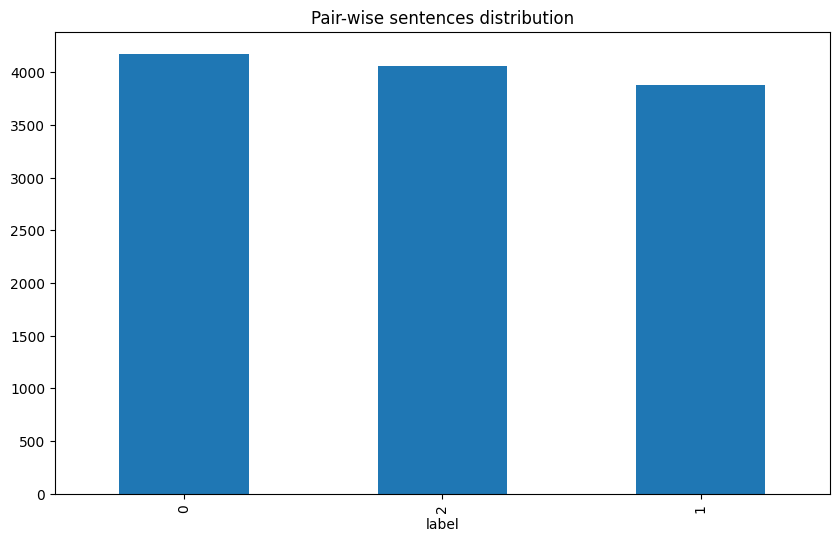

In [6]:
df.label.value_counts().plot(kind="bar", figsize=(10, 6), title="Pair-wise sentences distribution")
plt.show()

However, the dataset predominantly consists of English sentences.

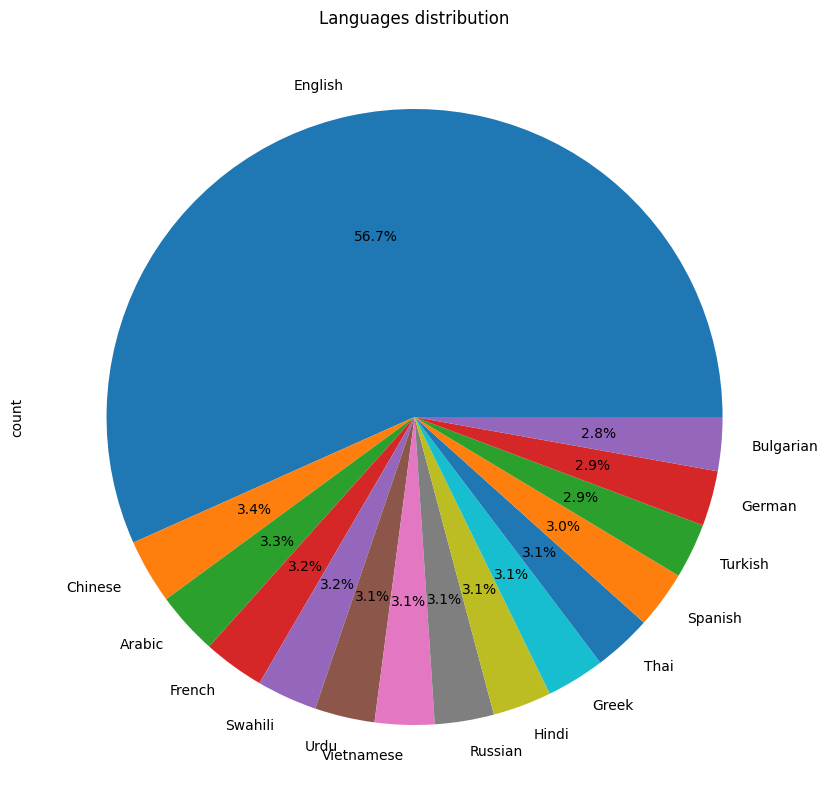

In [7]:
df.language.value_counts().plot(
    kind="pie", 
    figsize=(10, 10), 
    autopct='%1.1f%%', 
    title="Languages distribution"
)
plt.show()

#### MNLI dataset

We use `matched` version of test and train set because the dataset from the Challenge seems to match the same genre.

In [8]:
mnli_train = load_dataset("nyu-mll/glue", "mnli", split="train")
mnli_val = load_dataset("nyu-mll/glue", "mnli", split="validation_matched")

# Inspect the dataset
mnli_train_df = mnli_train.to_pandas()
mnli_train_df.head()

,premise,hypothesis,label,idx
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,0
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,1
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,2
3,How do you know? All this is their information...,This information belongs to them.,0,3
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,4


#### XNLI dataset

[XNLI: Evaluating Cross-lingual Sentence Representations](https://aclanthology.org/D18-1269/) (Conneau et al., EMNLP 2018)

In [9]:
XNLI_TRAIN_SIZE = 500_000  # Limit the number of examples as the dataset is very large

def load_xnli_datasets(languages: list, split="train"):
    datasets = []
    for lang in languages:
        xnli_lang = load_dataset("facebook/xnli", lang, split=split)
        xnli_lang = xnli_lang.add_column("lang_abv", [lang] * len(xnli_lang))
        datasets.append(xnli_lang)

    return concatenate_datasets(datasets).shuffle()

# We remove the English 'en' dataset as it is actually the MNLI set
languages = ['ar','bg','de','el','es','fr','hi','ru','sw','th','tr','ur','vi','zh']
xnli_train = load_xnli_datasets(languages, split="train").select(range(XNLI_TRAIN_SIZE))
xnli_val = load_xnli_datasets(languages, split="validation")

Now, we inspect the XNLI dataset.

In [10]:
xnli_train_df = xnli_train.to_pandas()
xnli_train_df.sample(10)

,premise,hypothesis,label,lang_abv
258951,Хорошие манеры можно культивировать .,Ты должен научиться хорошим манерам откуда-то .,1,ru
35938,"Ожидается , что это будет самым спорным термин...","Дела , связанные с бесплатной речью , были спо...",1,ru
79581,докато континентална гърция достига зенита си ...,gertis беше най-силният от на градове .,0,bg
266566,Yup bạn có chó là bạn bè của bạn gõ cửa một có...,Chó là bạn bè của chúng tôi .,0,vi
319951,"Bueno , a él no le importa mientras esté alime...",Su familia está formada por tres hijas y un hi...,1,es
20854,2 millions pour les candidats et les partis po...,2 millions ont été reversés aux candidats de l...,1,fr
178261,Sehemu kuu ya karatasi hii ni kwamba generaliz...,Generalizability ni kwenye karatasi kwa urefu .,1,sw
491502,566-ويقدر عبء الاحتياجات ( متطلبات الاختبار وح...,"وهذا الشرط , وان كان ضروريا , يستغرق الكثير من...",1,ar
347642,تعمیراتی نظام,تعمیر کی جگہ,0,ur
215965,将 抽样调查 的 逻辑 应用于 定性 案例 的 案例 分组 方法 .,将 想象力 应用于 案件 集群 方法 .,2,zh


### Data Augmentation

Use `NLPAug` library to augment the data by using synonyms, typo insertion and word swapping.

In [11]:
%pip install -qU nltk nlpaug

Note: you may need to restart the kernel to use updated packages.


In [12]:
from nlpaug.augmenter.word import RandomWordAug, SynonymAug
from nlpaug.augmenter.char import KeyboardAug

augmenters = [
    (SynonymAug(aug_src='wordnet', aug_p=0.1), 0.8),   # Synonym replacement
    (RandomWordAug(action='swap', aug_p=0.1), 0.1),    # Word swapping
    (KeyboardAug(aug_char_p=0.1, aug_word_p=0.1), 0.3) # Typo simulation
]

def augment_text(text, augmenter):
    try:
        result = augmenter.augment(text)
        # Handle list outputs from some augmenters
        return result[0] if isinstance(result, list) else str(result)
    except Exception as e:
        return str(text)  # Ensure string return

def create_augmented_df(df, augmenters, sample_frac=0.5):
    sample = df.sample(frac=sample_frac)
    augmented = []

    for _, row in tqdm(sample.iterrows(), total=len(sample)):
        for aug, weight in augmenters:
            if np.random.random() > weight:
                continue  # Skip this augmentation

            new_row = row.copy()
            premise = new_row['premise'] = augment_text(row['premise'], aug)
            hypothesis = new_row['hypothesis'] = augment_text(row['hypothesis'], aug)
            if premise != row["premise"] or hypothesis != row["hypothesis"]:
                augmented.append(new_row)

    return pd.DataFrame(augmented).convert_dtypes()

def augment_dataset(ds, augmenters):
    df_aug = create_augmented_df(df, augmenters)
    # Concatenate augmented dataset with original
    ds_aug = Dataset.from_pandas(df_aug)
    return concatenate_datasets([ds, ds_aug]).shuffle()

# challenge_train = augment_dataset(challenge_train, augmenters)

### Tokenizer

Training and evaluation use the `Trainer` API from the `transformers`. [How to Fine-Tune BERT for Text Classification](https://arxiv.org/pdf/1905.05583)

In [13]:
import evaluate

accuracy = evaluate.load("accuracy")
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

def tokenize(row, max_length=510):
    """Pre-processing class to handle text tokenization."""
    return tokenizer(
        row['premise'], 
        row['hypothesis'],
        padding='max_length', 
        truncation=True, 
        max_length=max_length, # Default: 512 - 2 tokens for CLS and SEP
        return_tensors="pt"    # Return PyTorch tensors
    )
    
def compute_metrics(eval_pred):
    """Compute accuracy on the validation set."""
    y_pred = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=y_pred, references=eval_pred.label_ids)

### Model
We use `XLM-RoBERTa` model from `transformers` library and add a classification head on top of it.

In [14]:
import torch.nn as nn
from transformers.models.xlm_roberta.modeling_xlm_roberta import (
    XLMRobertaModel, XLMRobertaForSequenceClassification
)

class XLMRobertaClassificationHeadWithMeanPooling(nn.Module):
    """Custom head for sentence-level classification tasks."""
    def __init__(self, config):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        if config.classifier_dropout is not None:
            self.dropout = nn.Dropout(config.classifier_dropout)
        else:
            self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        # Average pooling instead of taking the <s> token (equiv. to [CLS])
        x = self.avg_pool(features.permute(0, 2, 1)).squeeze(-1) 
        x = self.dropout(x)
        x = self.dense(x)
        x = nn.functional.gelu(x)   # Default: torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class XLMRobertaWithMeanPooling(XLMRobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config
        self.roberta = XLMRobertaModel(config, add_pooling_layer=False)
        self.classifier = XLMRobertaClassificationHeadWithMeanPooling(config)
        # Initialize weights and apply final processing
        self.post_init()

### Finetuning (MNLI + XNLI)

Finetune the model on the MNLI and XNLI dataset.

**Architecture:**  
- `xml-roberta-large` pre-trained model from Hugging Face

In [15]:
model = XLMRobertaWithMeanPooling.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=3)
model.to(device)  # Move model to GPU if available

Some weights of XLMRobertaWithMeanPooling were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaWithMeanPooling(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features

#### Hyperparameters

In [ ]:
model_dir = MODEL_DIR / f"{MODEL_BASENAME}-mnli-xnli"

training_args = TrainingArguments(
    output_dir=model_dir,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'  # Disabling wandb callbacks
)
# Tokenize data
mnli_train_tokenized = mnli_train.map(tokenize, batched=True)
xnli_train_tokenized = xnli_train.map(tokenize, batched=True)
challenge_val_tokenized = challenge_val.map(tokenize, batched=True)

# Concatenate the MNLI and XNLI datasets
train_tokenized = concatenate_datasets([mnli_train_tokenized, xnli_train_tokenized])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=challenge_val_tokenized,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

#### Training

In [ ]:
trainer.train()
torch.cuda.empty_cache()  # Free some unused memory
# Save the best model and the tokenizer to disk.
trainer.save_model(model_dir)
tokenizer.save_pretrained(model_dir)

Upload the model to Hugging Face Hub

In [ ]:
%pip install -qU huggingface-hub
!huggingface-cli login --token "$HF_TOKEN"

In [ ]:
REPOSITORY_NAME = f"ajayat/{MODEL_BASENAME}-mnli-xnli"

trainer.model.push_to_hub(REPOSITORY_NAME, private=True)
tokenizer.push_to_hub(REPOSITORY_NAME)

### Finetuning (Challenge)

#### Load the model


In [ ]:
PRETRAINED_MODEL_NAME = "joeddav/xlm-roberta-large-xnli"
MODEL_BASENAME = PRETRAINED_MODEL_NAME.rpartition('/')[2]

model = XLMRobertaWithMeanPooling.from_pretrained(
    PRETRAINED_MODEL_NAME, 
    hidden_dropout_prob=0.3,           # default 0.1
    attention_probs_dropout_prob=0.3,  # default 0.1
    num_labels=3
).to(device)  # Move model to GPU if available

#### Hyperparameters

In [ ]:
model_output_dir = MODEL_DIR / f"{MODEL_BASENAME}-finetuned"

training_args = TrainingArguments(
    output_dir=model_output_dir,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none'  # Disabling wandb callbacks
)
# Tokenize data
challenge_train_tokenized = challenge_train.map(tokenize, batched=True)
challenge_val_tokenized = challenge_val.map(tokenize, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=challenge_train_tokenized,
    eval_dataset=challenge_val_tokenized,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

#### Training

In [ ]:
trainer.train()
# Save the best model and the tokenizer to disk.
trainer.save_model(model_output_dir)
tokenizer.save_pretrained(model_output_dir)

Upload the model to HuggingFace Hub. (Optional)

In [ ]:
REPOSITORY_NAME = f"ajayat/{MODEL_BASENAME}-finetuned"

trainer.model.push_to_hub(REPOSITORY_NAME, private=True)
tokenizer.push_to_hub(REPOSITORY_NAME)

### Inference Optimization

In [16]:
%pip install -qU onnxruntime-gpu onnxruntime-tools onnxscript "transformers[onnx]" "optimum[onnxruntime]"

Note: you may need to restart the kernel to use updated packages.


#### Quantization

We define a function to export a model to ONNX format and apply some optimizations, such as quantization. We observed a speedup of x5 on CPU.

In [17]:
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic

def export_to_onnx(model, onnx_model_file: Path):
    """Exports a pre-trained model to the ONNX format and quantizes it."""
    # Minimal dummy input for tracing
    dummy_inputs = tokenize(
        dict(premise="This is a premise.", hypothesis="This is a hypothesis."),
    )
    torch.onnx.export(
        model.cpu().eval(),  # Ensure inference mode
        (dummy_inputs["input_ids"], dummy_inputs["attention_mask"]),
        onnx_model_file.as_posix(),
        input_names=['input_ids', 'attention_mask'],
        output_names=['logits'],
        dynamic_axes={
            "input_ids": {0: "batch_size", 1: "seq_len"},
            "attention_mask": {0: "batch_size", 1: "seq_len"},
            "logits": {0: "batch_size"},
        },
        opset_version=17,  # ONNX version
    )
    quantize_dynamic(onnx_model_file, onnx_model_file)
    print(f"Model exported and quantized to {onnx_model_file}!")

model_output_dir = MODEL_DIR / "xlm-roberta-large-mnli-xnli"
model = XLMRobertaForSequenceClassification.from_pretrained(model_output_dir, num_labels=3)
# Export and optimize the model
export_to_onnx(model, model_output_dir / "model.onnx")

Model exported and quantized to /home/adrien/Natural Language Inference/models/xlm-roberta-large-mnli/model.onnx!


#### Inference with ONNX Runtime

In [19]:
ONNX_MODEL_PATH = model_output_dir / "model.onnx"
sess_options = ort.SessionOptions()
sess_options.intra_op_num_threads = 8
sess_options.inter_op_num_threads = 4

ort_session = ort.InferenceSession(
    ONNX_MODEL_PATH, 
    providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
    sess_options=sess_options
)

def infer(premise, hypothesis) -> int:
    example = tokenize(dict(premise=premise, hypothesis=hypothesis))
    inputs = dict(
        input_ids=np.array(list(example["input_ids"])).astype(np.int64),
        attention_mask=np.array(list(example["attention_mask"])).astype(np.int64),
    )
    logits = ort_session.run(None, inputs)[0]  # Inference ONNX
    return logits.ravel()

def predictions(dataset: pd.DataFrame):
    logits = [infer(row['premise'], row['hypothesis']) for row in tqdm(dataset)]
    return np.argmax(logits, axis=-1)

2025-04-13 23:59:37.885939098 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 366 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.


### Evaluation & Visualization

Compute accuracy on the challenge validation set.

In [21]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

training_args = TrainingArguments(
    output_dir="/tmp",
    per_device_eval_batch_size=16,
    report_to='none'
)
challenge_val_tokenized = challenge_val.map(tokenize, batched=True)
trainer = Trainer(model=model, args=training_args)

preds = trainer.predict(challenge_val_tokenized).predictions
y_pred = np.argmax(preds, axis=-1)
# y_pred = predictions(challenge_val) # Uncomment this line to use ONNX inference
y_true = challenge_val['label']
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.3f}")

Map:   0%|          | 0/3636 [00:00<?, ? examples/s]

100%|██████████| 3636/3636 [19:12<00:00,  3.16it/s]


Accuracy: 0.839


Display the confusion matrix using `scikit-learn`.

<Figure size 800x600 with 0 Axes>

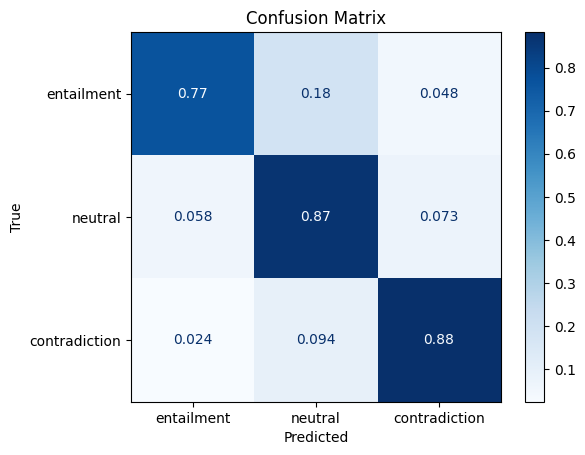

In [22]:
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=['entailment', 'neutral', 'contradiction'],
    cmap='Blues',
    normalize='true',
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Entailment', 'Neutral', 'Contradiction']))


Classification Report:
               precision    recall  f1-score   support

   Entailment       0.91      0.77      0.83      1263
      Neutral       0.74      0.87      0.80      1144
Contradiction       0.88      0.88      0.88      1229

     accuracy                           0.84      3636
    macro avg       0.84      0.84      0.84      3636
 weighted avg       0.85      0.84      0.84      3636



#### Submission file for Kaggle (Optional)

In [24]:
df_test = pd.read_csv(ROOT_PATH / "data/train.csv")
test_tokenized = Dataset.from_pandas(df_test).map(tokenize, batched=True)
# Compute predictions
pred = trainer.predict(test_tokenized)

# Create submission csv file
submission = df_test.id.copy().to_frame()
submission["prediction"] = np.argmax(pred.predictions, axis=1)

submission.to_csv(ROOT_PATH / "data/submission.csv", index=False)
print("Submission file saved.")

Map:   0%|          | 0/12120 [00:00<?, ? examples/s]

/home/adrien/.pytorch_venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Submission file saved.


### Conclusion

We first fine-tuned a pre-trained model on the full MNLI dataset, followed by further training on a 1M-example subset of the XNLI dataset. This approach gives a validation accuracy of 0.853 on the challenge dataset.

In a separate experiment, we fine-tuned an already pre-trained HuggingFace model `joeddav/xlm-roberta-large-xnli` directly on the challenge dataset. This method achieved a slightly higher test accuracy of 0.914 on the Kaggle competition dataset, placing us 10th on the leaderboard.

#### Further improvements

- **Finetuning**: finetune `xlm-roberta-large` on the full XNLI dataset, which is +5M examples.